# NATRE microstructure dataset

Study NATRE dataset, reproduce Ferrari & Polzin (2005)

In [1]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import xarray as xr
from IPython.display import Image

import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")

%watermark -iv

matplotlib : 3.4.3
cf_xarray  : 0.5.3.dev29+g3660810.d20210729
dcpy       : 0.1
numpy      : 1.21.3
tqdm       : 4.62.3
distributed: 2021.10.0
xarray     : 0.17.1.dev3+g48378c4b1
eddydiff   : 0.1



In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=2, threads_per_worker=2)
client

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44397 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45051' processes=2 threads=4, memory=31.09 GiB>

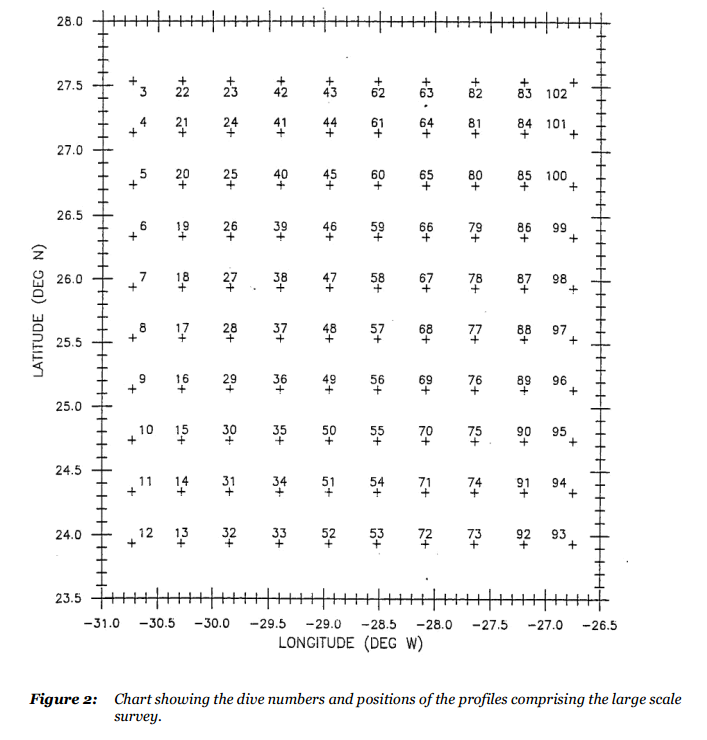

In [3]:
Image("../images/natre-large-scale.png")

## Read dataset

created using ``eddydiff.natre.combine_natre_files()``



In [4]:
natre = ed.natre.read_natre().load()

/home/deepak/work/python/xarray/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


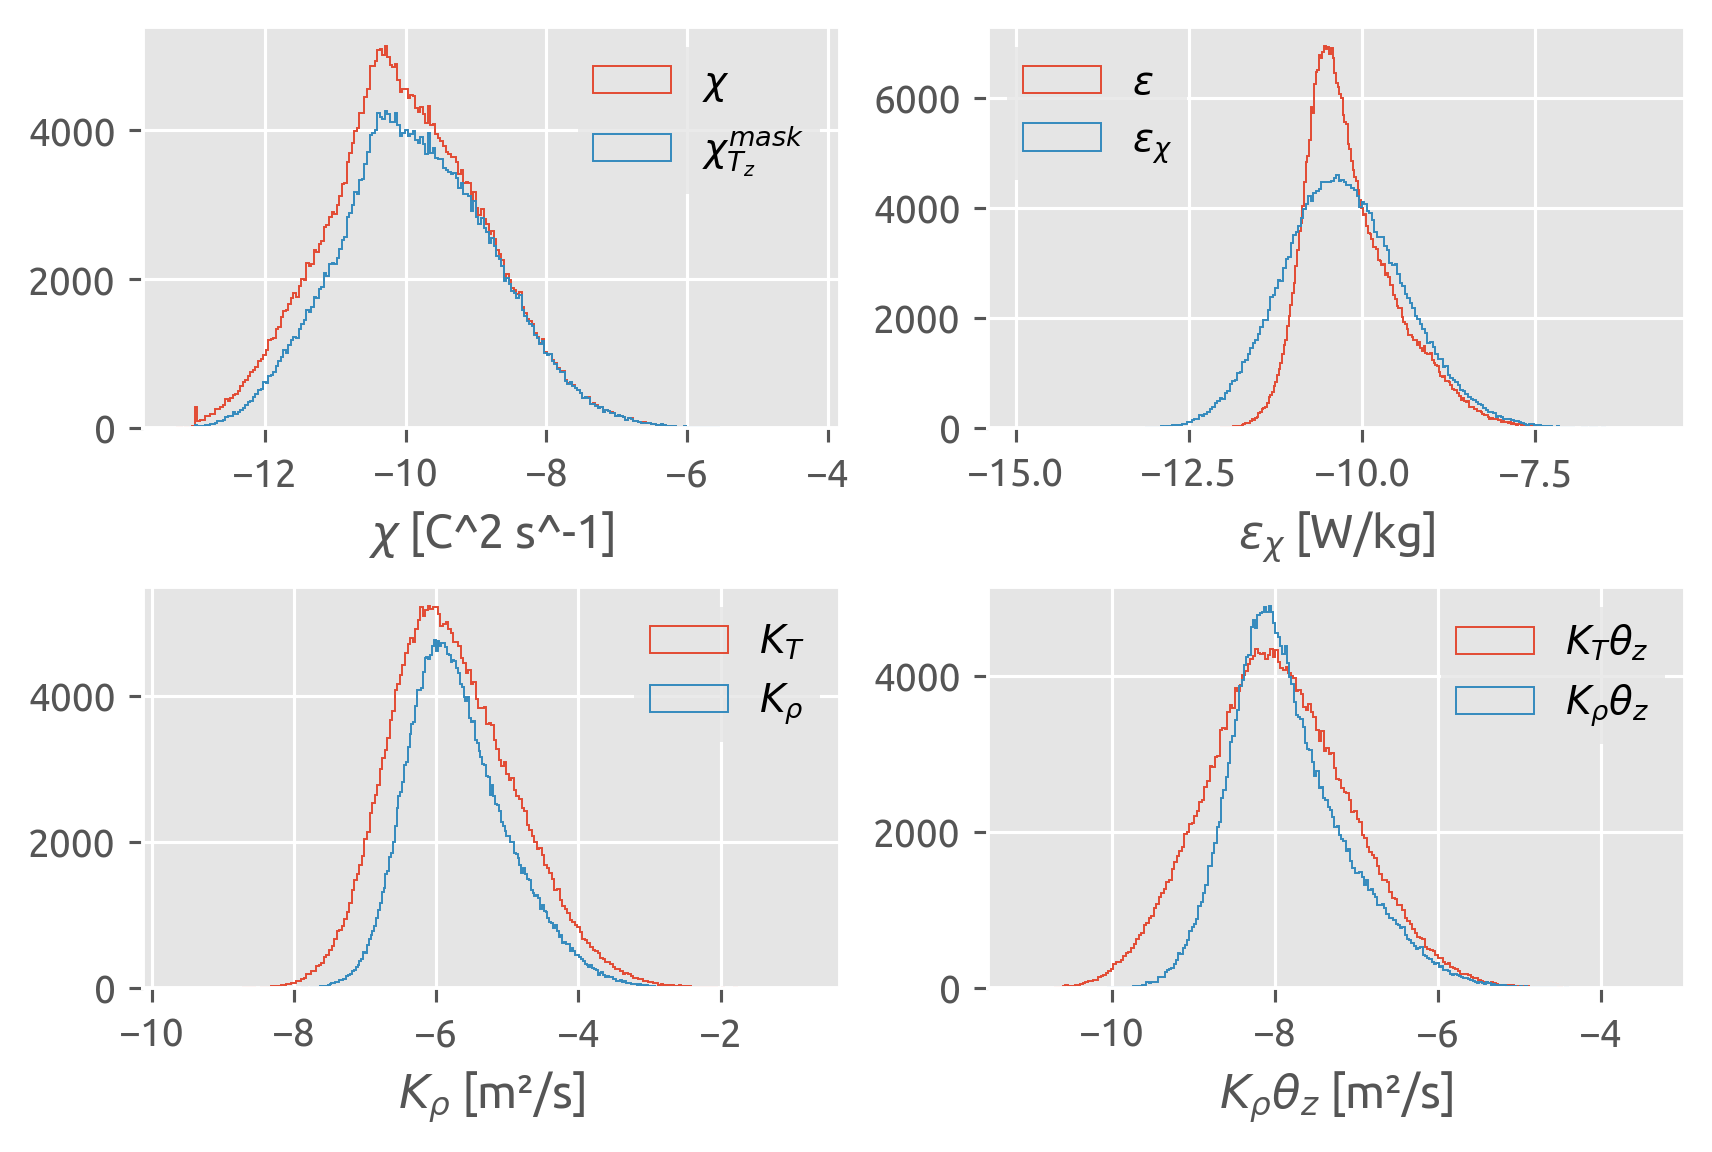

In [5]:
ed.plot.histogram_turb_estimates(natre)

## TS plot

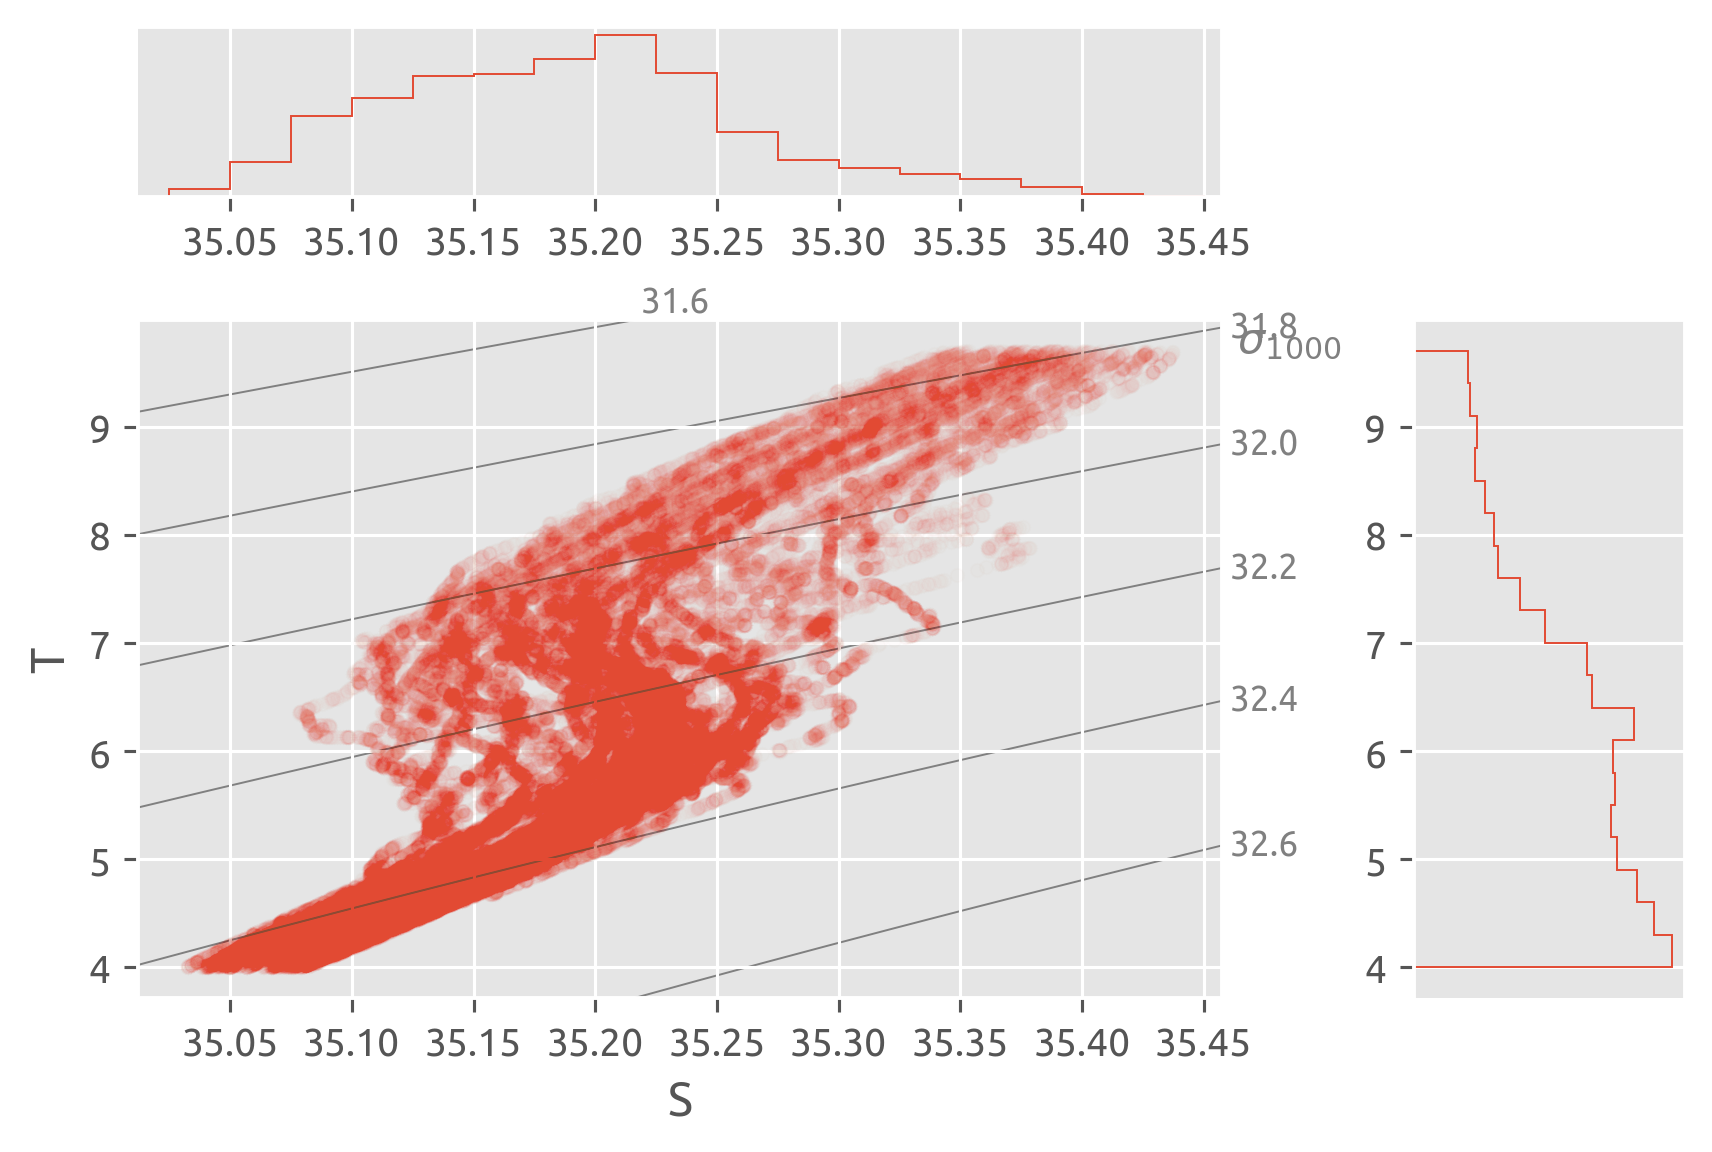

In [6]:
hdl, axes = dcpy.oceans.TSplot(
    natre.salt[::2],
    natre.theta[::2],
    Pref=1000,
    # rho_levels=bins,
    Sbins=np.arange(35, 35.5, 0.025),
    Tbins=np.arange(4, 10, 0.3),
    hexbin=False,
    plot_kwargs={"alpha": 0.01},
)

In [7]:
(
    natre["chi"].rolling(depth=100, center=True, min_periods=1).mean().compute()
).plot.line(
    y="depth",
    col="longitude",
    row="latitude",
    yincrease=False,
    xlim=[1e-12, 1e-7],
    ylim=(2000, 0),
    xscale="log",
)

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f70c8187340>>, <Task finished name='Task-481' coro=<Cluster._sync_cluster_info() done, defined at /home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:45051 after 3 s')>)
Traceback (most recent call last):
  File "/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/comm/core.py", line 284, in connect
    comm = await asyncio.wait_for(
  File "/home/deepak/miniconda3/envs/dcpy/lib/python3.8/asyncio/tasks.py", line 498, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/ioloop.py", line 741

## Procedure

The large-scale average operator ⟨⟩ represents 
1. a horizontal average over the survey lateral scale,
2. a vertical average over O(100) m, and
3. a time average over the 18-day survey.


The mean fields are derived by averaging all variables along neutral-density surfaces $γ_n$

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In theory, these bins are approx. 100m apart in neutral density

### Choose bins

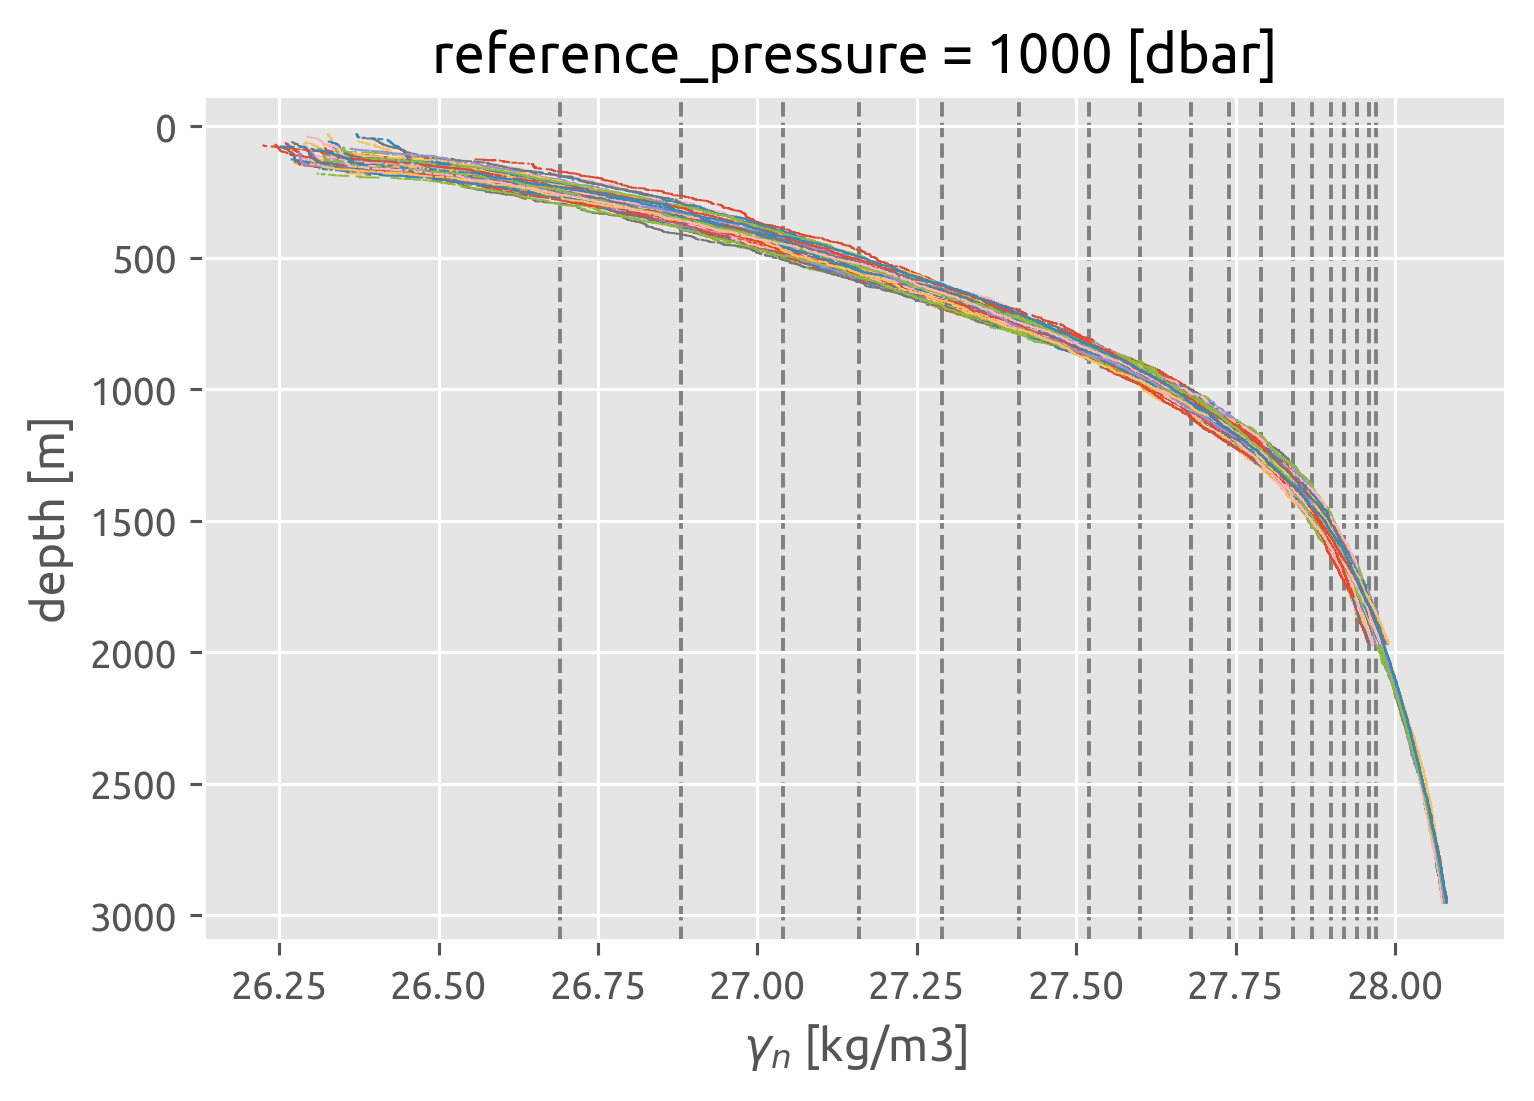

In [8]:
# bins = (
#    natre.gamma_n.mean(["latitude", "longitude"])
#    .interp(depth=np.arange(150, 2001, 100))
#    .dropna("depth")
#    .data
# )

bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))
natre.gamma_n.stack({"latlon": ["latitude", "longitude"]}).drop("latlon").cf.plot(
    hue="latlon",
    y="depth",
    lw=0.5,
    add_legend=False,
    yincrease=False,
)
dcpy.plots.linex(bins)

## Make estimate

 
**Vertical gradients:** `ed.sections.fit1D`

> Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$, $S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

I don't understand this. The bins are O(100m) apart, so how do you "fit" straight lines over O(100)-m to a profile that has points every O(100)m.

**Horizontal gradients:** `ed.sections.fit2D`

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

Ke is totally wrong!, I need to fix my plane fitting

### Bin-average in density bins

In [9]:
micro = ed.sections.bin_average_vertical(
    natre.reset_coords("pres"), "neutral_density", bins
)
micro

<xarray.Dataset>
Dimensions:             (gamma_n: 17, bounds: 2)
Coordinates:
  * gamma_n             (gamma_n) float64 26.79 26.96 27.1 ... 27.93 27.95 27.96
    pres                (gamma_n) float64 303.1 407.2 ... 1.826e+03 1.902e+03
    reference_pressure  int64 1000
    num_obs             (gamma_n) int64 19763 19424 17093 ... 18916 21881 10032
    gamma_n_bounds      (bounds, gamma_n) float64 26.69 26.88 ... 27.96 27.97
Dimensions without coordinates: bounds
Data variables: (12/18)
    chi                 (gamma_n) float64 6.112e-09 3.64e-09 ... 2.707e-10
    eps                 (gamma_n) float64 6.149e-10 5.53e-10 ... 1.16e-10
    salt                (gamma_n) float64 36.16 35.87 35.68 ... 35.13 35.1 35.09
    temp                (gamma_n) float64 15.64 13.83 12.45 ... 4.776 4.47 4.271
    theta               (gamma_n) float64 15.75 13.92 12.52 ... 4.393 4.187
    pden                (gamma_n) float64 1.031e+03 1.031e+03 ... 1.032e+03
    ...                  ...
    Kt                  (gamma_n) float64 2.416e-05 2.335e-05 ... 1.511e-05
    KtTz                (gamma_n) float64 1.398e-07 1.077e-07 ... 3.357e-08
    dTdz_m              (gamma_n) float64 0.01861 0.01519 ... 0.002752 0.002534
    N2_m                (gamma_n) float64 1.95e-05 1.679e-05 ... 1.355e-06
    Krho_m              (gamma_n) float64 6.307e-06 6.589e-06 ... 1.713e-05
    Kt_m                (gamma_n) float64 8.828e-06 7.89e-06 ... 2.107e-05
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

Replicate some Ferrari & Polzin (2005) figures. $K_ρ, ε$ look OK. $K_e$ is wrong, something is wrong with my slope estimate / plane fitting

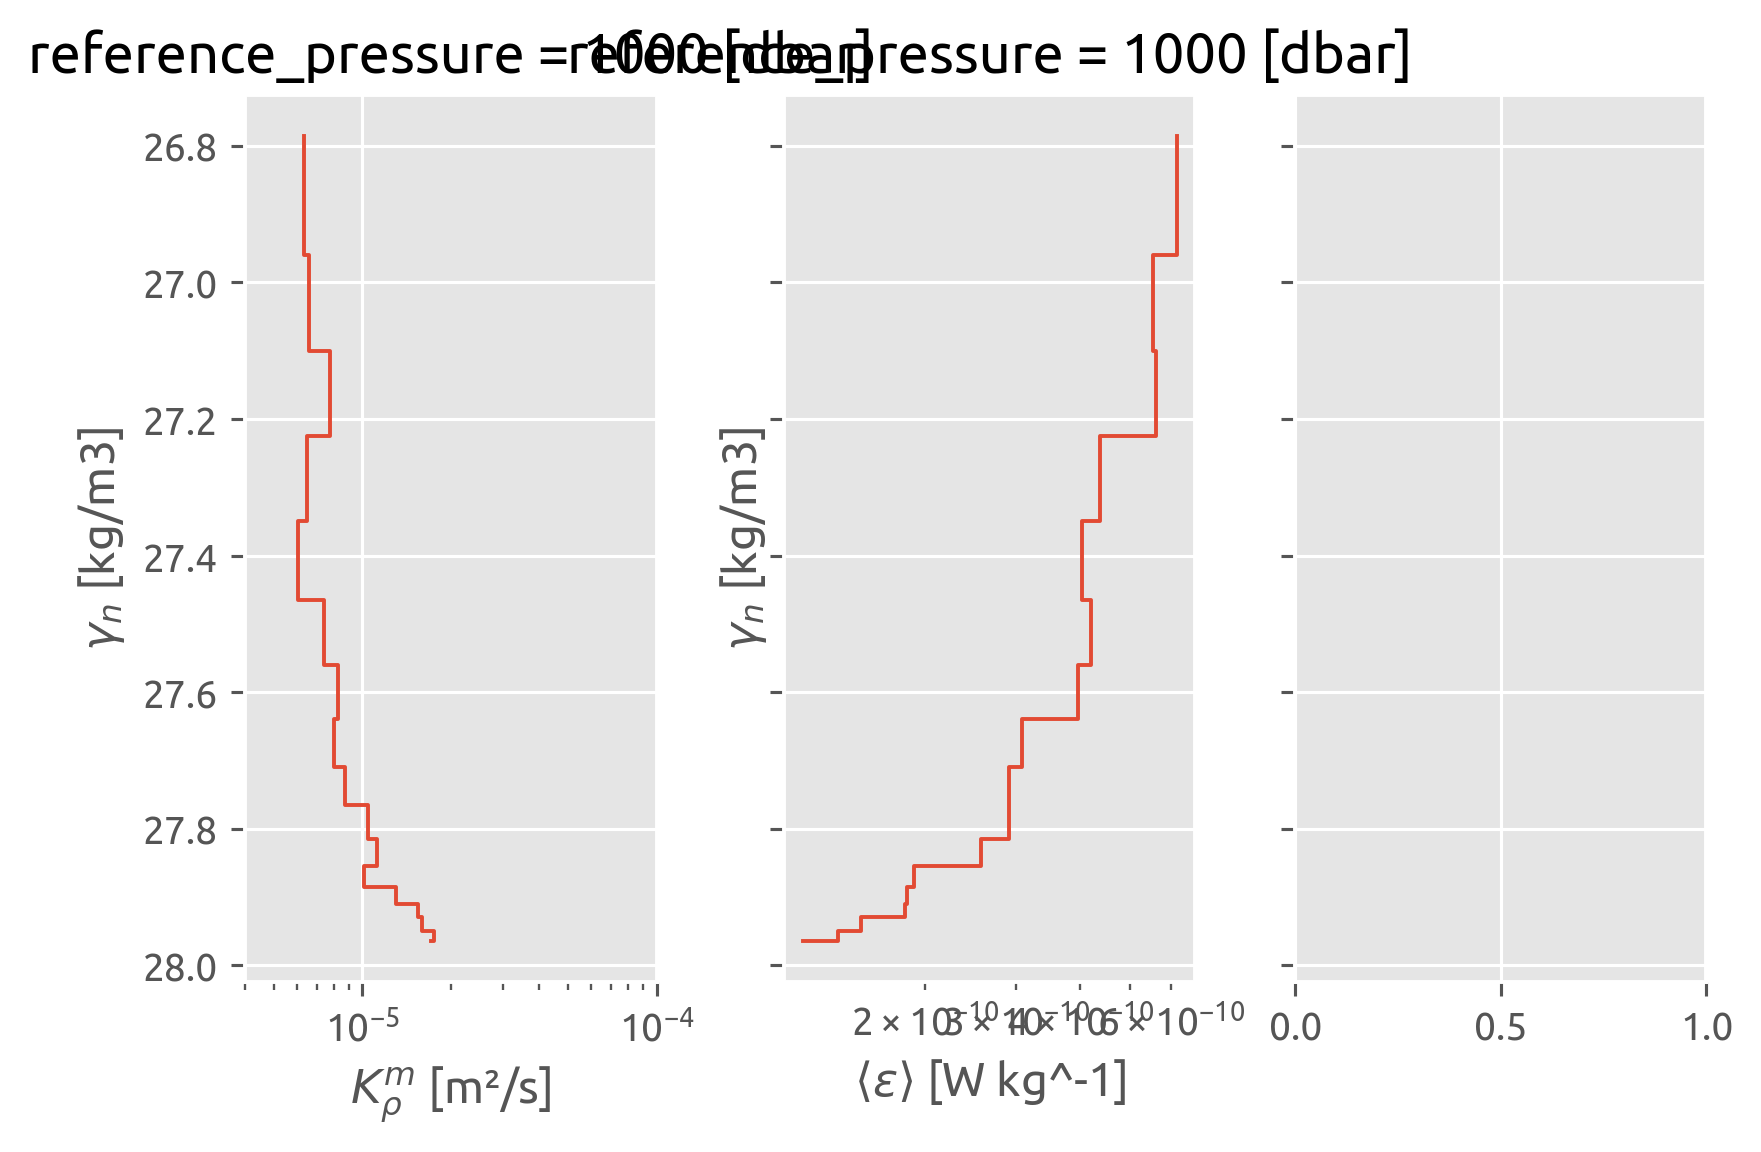

In [10]:
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
micro.drop_vars("pres").Krho_m.cf.plot.step(xscale="log", xlim=(4e-6, 1e-4), ax=ax[0])
micro.drop_vars("pres").eps.cf.plot.step(ax=ax[1], xscale="log")
# chidens["Ke"].cf.plot(ax=ax[2])

### Constructing mean profiles

I experimented with constructing a mean profile using a large number of γ_n bins, and then fitting straight lines in approx 100m bins.

I have instead decided to do a similar fitting procedure in `ed.sections.fit1D` for each chosen O(100m) wide density bin. Otherwise I would need to figure out how to go from $θ_z$ in this mean profile to an appropriate value for the density bin.

In [55]:
bins = ed.sections.choose_bins(natre.gamma_n.mean(["latitude", "longitude"]), np.arange(150, 2001, 10), decimals=6)

props = natre[["temp", "salt", "gamma_n"]].interpolate_na("depth")
props["depth_"] = ("depth", props.depth.data)
mean_props = props.groupby_bins("gamma_n", bins).mean()

In [56]:
sliding = (
    mean_props  # .swap_dims({"gamma_n_bins": "depth_"})
    # .rename({"depth_": "depth"})
    .rolling(gamma_n_bins=10, center=True).construct("bin")
)
Δz = sliding.depth_.isel(bin=[-1, 0]).diff("bin").squeeze()
gradients = sliding.polyfit("bin", deg=1).sel(degree=1) / Δz
mean_props["Tz"] = gradients.temp_polyfit_coefficients
mean_props["Sz"] = gradients.salt_polyfit_coefficients
mean_props["N2"] = -9.81 / 1030 * gradients.gamma_n_polyfit_coefficients
mean_props

### Mean gradients in a chosen O(100m) γ_n bin

In [61]:
bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))
binned = natre.reset_coords().groupby_bins("gamma_n", bins=bins)

i = 0
for label, group in binned:
    i = i+1
    if i == 5:
        break

In [63]:
ds = group.unstack()
ds

<xarray.Dataset>
Dimensions:             (latitude: 10, longitude: 10, depth: 547)
Coordinates:
  * latitude            (latitude) float64 27.5 27.1 26.7 ... 24.7 24.3 23.9
  * longitude           (longitude) float64 -30.7 -30.3 -29.8 ... -27.2 -26.8
  * depth               (depth) float64 594.6 595.0 595.8 ... 495.8 497.8 499.8
Data variables: (12/18)
    chi                 (latitude, longitude, depth) float64 1e-15 ... 6.867e-11
    eps                 (latitude, longitude, depth) float64 7.443e-11 ... 2....
    salt                (latitude, longitude, depth) float64 35.56 ... 35.62
    temp                (latitude, longitude, depth) float64 11.7 11.7 ... 11.89
    gamma_n             (latitude, longitude, depth) float64 27.16 ... 27.16
    pres                (latitude, longitude, depth) float64 599.5 ... 503.5
    ...                  ...
    chi_masked          (latitude, longitude, depth) float64 1e-15 ... 6.867e-11
    Krho                (latitude, longitude, depth) float64 1.744e-06 ... 4....
    KrhoTz              (latitude, longitude, depth) float64 1.276e-08 ... 6....
    eps_chi             (latitude, longitude, depth) float64 3.988e-16 ... 1....
    Kt                  (latitude, longitude, depth) float64 9.347e-12 ... 1....
    KtTz                (latitude, longitude, depth) float64 6.836e-14 ... 2....
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

In [149]:
ed.sections.average_density_bin(group).dTdz_m

-0.011270900780997465
0.012996880869341362


<xarray.DataArray 'dTdz_m' ()>
array(0.0112709)
Attributes:
    name:     $∂_z θ_m$
    units:    °C/m

In [154]:
group.unstack().depth

<xarray.DataArray 'depth' (depth: 547)>
array([594.6, 595. , 595.8, ..., 495.8, 497.8, 499.8])
Coordinates:
  * depth    (depth) float64 594.6 595.0 595.8 596.2 ... 493.4 495.8 497.8 499.8

<xarray.DataArray 'depth' (depth: 10)>
array([551.590043, 561.407269, 572.258639, 583.53746 , 593.436723, 604.726001,
       616.072442, 627.213435, 637.901493, 648.193224])
Coordinates:
    gamma_n_bins  (depth) object (27.16, 27.173] ... (27.277, 27.29]
  * depth         (depth) float64 551.6 561.4 572.3 583.5 ... 627.2 637.9 648.2
-0.011354461927299291


array(-0.01135446)

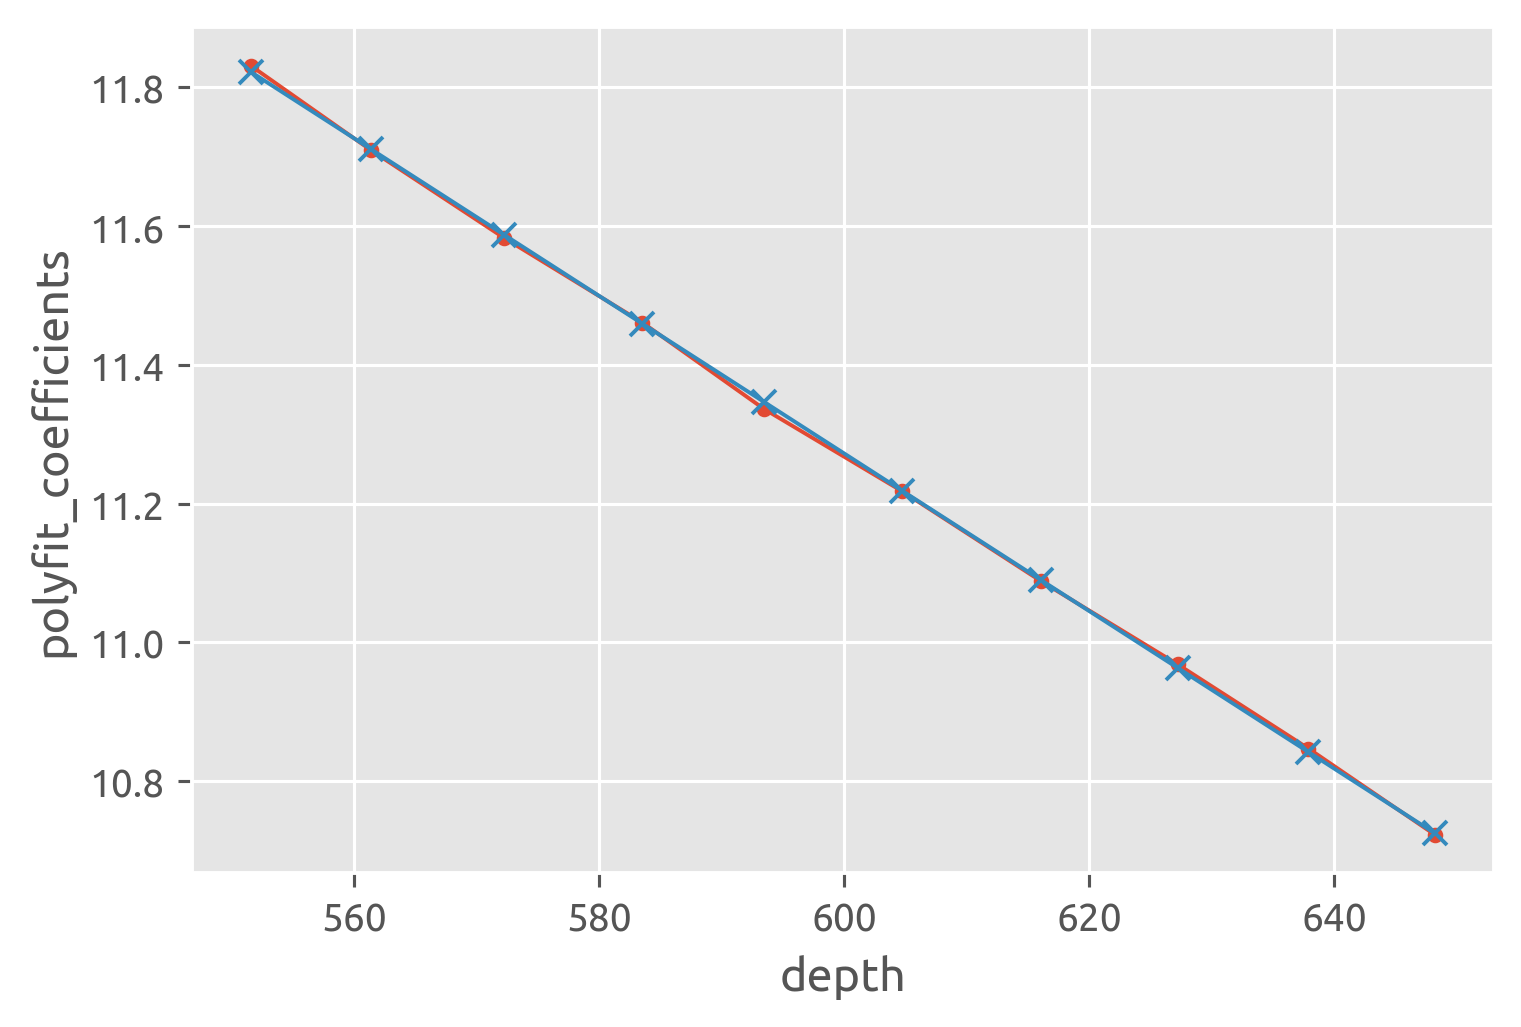

In [155]:
ed.sections.fit1D(group, "theta", "depth", debug=True)

## Computing along latitude and longitude lines

In [ ]:
def compute_single_line(section):
    return ed.sections.bin_average_vertical(
        section.cf.stack({"cast": ("latitude", "longitude")}).drop("cast"),
        "neutral_density",
        bins,
    )


lonlines = natre.groupby("longitude", squeeze=False).map(compute_single_line)
latlines = natre.groupby("latitude", squeeze=False).map(compute_single_line)

latlines.to_netcdf("../datasets/natre-along-lat-lines.nc")
lonlines.to_netcdf("../datasets/natre-along-lon-lines.nc")